# Debiasing Recidivism Predictions


Department of Computer Science

Stanford University

Team: Jonathan Hollenbeck, Manish Pandit and Amita C. Patil

(jonoh, manish7, amita2)@stanford.edu

## Overview

Recidivism is one of the most fundamental concepts in criminal justice. It refers to a person's relapse into criminal behavior, often after the person receives sanctions or undergoes intervention for a previous crime.

Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. There are also two leading nationwide tools offered by commercial vendors.

We set out to assess one of the commercial tools made by Northpointe, Inc. to discover the underlying accuracy of their recidivism algorithm and to test whether the algorithm was biased against certain groups.

Our goal is to detect any bias against certain groups exhibited the risk scores from Northpointe's algorithm named COMPAS.  We also investigate techniques and methods to reduce the bias while maintaining the accuracy of the predictions.

We plan to utilize the AI Fairness 360 toolkit from IBM.  The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.

## Dataset

We leverage a dataset that contains more than 10,000 criminal defendants in Broward County, Florida. The dataset contains COMPAS software predicted recidivism rates along with the rate that actually occurred over a two-year period. When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of “Risk of Recidivism” and “Risk of Violent Recidivism.”  We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [47]:
# datafiles
compas_file = 'compas-scores-two-years.csv'

In [48]:
compas_df = pd.read_csv(compas_file)
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
id                         7214 non-null int64
name                       7214 non-null object
first                      7214 non-null object
last                       7214 non-null object
compas_screening_date      7214 non-null object
sex                        7214 non-null object
dob                        7214 non-null object
age                        7214 non-null int64
age_cat                    7214 non-null object
race                       7214 non-null object
juv_fel_count              7214 non-null int64
decile_score               7214 non-null int64
juv_misd_count             7214 non-null int64
juv_other_count            7214 non-null int64
priors_count               7214 non-null int64
days_b_screening_arrest    6907 non-null float64
c_jail_in                  6907 non-null object
c_jail_out                 6907 non-null object
c_case_number              7192 non

There are a number of reasons to remove rows because of missing data:

1. If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
2. We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
3. In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
4. We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [49]:
compas_df = compas_df[np.isfinite(compas_df['days_b_screening_arrest'])]
compas_df = compas_df[compas_df['days_b_screening_arrest'] >= -30.]
compas_df = compas_df[compas_df['days_b_screening_arrest'] <= 30.]
compas_df = compas_df[compas_df['is_recid'] != -1]
compas_df = compas_df[compas_df['c_charge_degree'] != 'O']
compas_df = compas_df[compas_df['score_text'] != 'N/A']
jail_term = pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])
jail_term = pd.to_timedelta(jail_term)
compas_df['length_of_stay'] = jail_term.dt.days

In [50]:
column_list = [
    'sex', 'race', 'age', 'age_cat', 'juv_fel_count', 'decile_score',
    'juv_misd_count', 'juv_other_count', 'priors_count', 'c_days_from_compas',
    'decile_score.1', 'score_text', 'v_decile_score', 'v_score_text', 'priors_count.1',
    'c_charge_degree', 'c_charge_desc', 'days_b_screening_arrest',
    'length_of_stay', 'two_year_recid'
]

In [51]:
compas_df = compas_df[column_list]

In [52]:
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 20 columns):
sex                        6172 non-null object
race                       6172 non-null object
age                        6172 non-null int64
age_cat                    6172 non-null object
juv_fel_count              6172 non-null int64
decile_score               6172 non-null int64
juv_misd_count             6172 non-null int64
juv_other_count            6172 non-null int64
priors_count               6172 non-null int64
c_days_from_compas         6172 non-null float64
decile_score.1             6172 non-null int64
score_text                 6172 non-null object
v_decile_score             6172 non-null int64
v_score_text               6172 non-null object
priors_count.1             6172 non-null int64
c_charge_degree            6172 non-null object
c_charge_desc              6167 non-null object
days_b_screening_arrest    6172 non-null float64
length_of_stay             6172 non-

In [53]:
compas_df.head()

,sex,race,age,age_cat,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,decile_score.1,score_text,v_decile_score,v_score_text,priors_count.1,c_charge_degree,c_charge_desc,days_b_screening_arrest,length_of_stay,two_year_recid
0,Male,Other,69,Greater than 45,0,1,0,0,0,1.0,1,Low,1,Low,0,F,Aggravated Assault w/Firearm,-1.0,0,0
1,Male,African-American,34,25 - 45,0,3,0,0,0,1.0,3,Low,1,Low,0,F,Felony Battery w/Prior Convict,-1.0,10,1
2,Male,African-American,24,Less than 25,0,4,0,1,4,1.0,4,Low,3,Low,4,F,Possession of Cocaine,-1.0,1,1
5,Male,Other,44,25 - 45,0,1,0,0,0,0.0,1,Low,1,Low,0,M,Battery,0.0,1,0
6,Male,Caucasian,41,25 - 45,0,6,0,0,14,1.0,6,Medium,2,Low,14,F,Possession Burglary Tools,-1.0,6,1


### Demographic breakdown

In [54]:
compas_df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [55]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [56]:
compas_df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [57]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [58]:
compas_df['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

### Corelation between lenght of stay in jail and decile score.
There is a positive corelation between length of stay and decile score, making it a useful feature for prediction.

In [59]:
compas_df[['length_of_stay', 'decile_score']].corr()

,length_of_stay,decile_score
length_of_stay,1.000000,0.207478
decile_score,0.207478,1.000000


In [60]:
compas_df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

### Recidivism statistics

In [61]:
recid = compas_df['two_year_recid']
print('Number of recidivism cases:', recid[recid == 1].sum())
print('percentage of recidivism cases: %.2f%%' % (recid[recid == 1].sum() / len(recid)))

Number of recidivism cases: 2809
percentage of recidivism cases: 0.46%


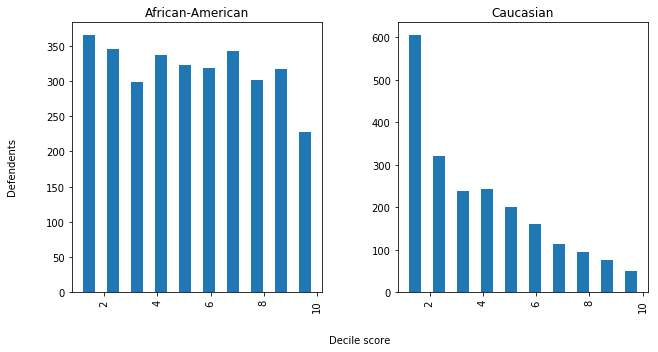

In [62]:
race_score_df = compas_df[['race', 'decile_score']]
race_score_df = race_score_df[(race_score_df['race'] 
                    == 'African-American') | (race_score_df['race'] == 'Caucasian')]
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,5))
race_score_df.hist(column='decile_score',by='race', ax=axes, rwidth=.5)

fig.text(0.5, 0.01, 'Decile score', ha='center')
fig.text(0.01, 0.5, 'Defendents', va='center', rotation='vertical')
fig.savefig('decile_scores.png')

In [63]:
charge_list = compas_df['c_charge_desc'].unique().tolist()
print(charge_list[:15])
charge_list = ['{}'.format(s) for s in charge_list]

['Aggravated Assault w/Firearm', 'Felony Battery w/Prior Convict', 'Possession of Cocaine', 'Battery', 'Possession Burglary Tools', 'arrest case no charge', 'Poss 3,4 MDMA (Ecstasy)', 'Poss3,4 Methylenedioxymethcath', 'Felony Driving While Lic Suspd', 'Grand Theft in the 3rd Degree', 'Driving While License Revoked', 'Possession Of Heroin', 'Battery on Law Enforc Officer', 'Possession Of Methamphetamine', 'Introduce Contraband Into Jail']


In [64]:
from spacy.lang.en import English
nlp = English()
charge_list_doc = [nlp(c) for c in charge_list]
charge_list_tokens = []
for doc in charge_list_doc:
    str = ''
    for token in doc:
        if token.is_alpha:
            str += ' ' + token.text.lower()
    charge_list_tokens.append(str)
charge_list_tokens[:15]

[' aggravated assault w firearm',
 ' felony battery w prior convict',
 ' possession of cocaine',
 ' battery',
 ' possession burglary tools',
 ' arrest case no charge',
 ' poss mdma ecstasy',
 ' methylenedioxymethcath',
 ' felony driving while lic suspd',
 ' grand theft in the degree',
 ' driving while license revoked',
 ' possession of heroin',
 ' battery on law enforc officer',
 ' possession of methamphetamine',
 ' introduce contraband into jail']

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [66]:
tfidf_enc = TfidfVectorizer(binary=True)
X = tfidf_enc.fit_transform(charge_list_tokens)

In [67]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
print(kmeans.labels_)

[1 1 2 1 2 0 4 0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 4 0 0 0 0 0 0 2 1 4 4 0 1 1 0
 4 1 0 3 2 0 1 0 2 4 0 0 0 0 0 0 4 1 0 3 0 0 0 2 1 3 1 0 1 1 0 2 0 0 0 0 1
 1 1 0 1 1 0 0 1 4 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 3 0 0 1 1 0 3 3 2 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 4 0 0 0 0 0 4 2 0 1 0 0 0 2 0 4 2 0 0 0
 2 0 0 0 0 0 0 0 0 0 1 0 0 1 2 0 4 0 2 0 4 1 0 1 0 4 1 4 0 0 0 0 3 0 1 0 0
 0 0 0 0 0 1 4 0 4 0 0 0 0 1 0 0 0 0 0 2 1 0 1 0 0 0 0 0 1 3 1 1 0 0 2 0 0
 1 0 0 0 4 3 0 0 0 0 0 4 0 0 0 2 4 0 0 2 0 0 0 0 4 3 0 0 4 4 1 0 0 0 0 0 0
 0 0 0 0 0 4 0 0 2 0 0 1 0 1 0 0 0 0 4 0 0 0 0 0 4 0 2 0 2 0 0 0 0 1 0 0 0
 0 0 0 4 0 0 0 0 1 2 0 0 0 0 0 2 1 2 0 0 0 0 0 4 2 4 0 0 0 0 1 0 0 0 0 0 3
 0 0 0 0 0 0 0 2 2 0 0 3 2 1 3 1 1 0 0 2]


In [68]:
#for c, l in zip(charge_list, kmeans.labels_):
#    print('{} : {}'.format(c, l))

In [69]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [70]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)

In [71]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(charge_list_tokens))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0610 19:02:31.302657 4639626688 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [72]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(message_embeddings)

In [73]:
charge_desc_dict = {}
for c, l in zip(charge_list, kmeans.labels_):
    charge_desc_dict[c] = l
i = 0
for k, v in charge_desc_dict.items():
    print(k, v)
    i += 1
    if i > 20:
        break

Aggravated Assault w/Firearm 4
Felony Battery w/Prior Convict 4
Possession of Cocaine 2
Battery 4
Possession Burglary Tools 4
arrest case no charge 4
Poss 3,4 MDMA (Ecstasy) 2
Poss3,4 Methylenedioxymethcath 0
Felony Driving While Lic Suspd 3
Grand Theft in the 3rd Degree 4
Driving While License Revoked 3
Possession Of Heroin 2
Battery on Law Enforc Officer 4
Possession Of Methamphetamine 2
Introduce Contraband Into Jail 2
Lewd/Lasc Battery Pers 12+/<16 0
Susp Drivers Lic 1st Offense 3
Carrying Concealed Firearm 4
Pos Cannabis W/Intent Sel/Del 2
Tampering With Physical Evidence 4
Att Tamper w/Physical Evidence 3


In [74]:
compas_df['c_charge_desc_id'] = compas_df['c_charge_desc'].map(lambda x: charge_desc_dict.get(x, 0))

In [75]:
def convert_columns(df, conversion_dict): # modify df in place
    for col_key in conversion_dict.keys():
        key_dict = conversion_dict[col_key]
        df[col_key] = df[col_key].apply(lambda x: key_dict[x])

races = np.unique(compas_df['race'])
conversion_dict = {
    'sex': { 'Female': 1, 'Male': 0 },
    'age_cat': { 'Less than 25': -1, '25 - 45': 0, 'Greater than 45': 1},
    'score_text': { 'High': 1, 'Low': -1, 'Medium': 0 },
    'v_score_text': { 'High': 1, 'Low': -1, 'Medium': 0 },
    'race': dict(map(lambda i: (races[i],i), range(len(races)))),
    'c_charge_degree': { 'M': 0, 'F': 1} # misdemeanor/felony
}
convert_columns(compas_df, conversion_dict)


In [76]:
compas_df = compas_df.drop(columns='c_charge_desc')
column_list = [
    'sex', 'race', 'age', 'age_cat', 'juv_fel_count', 'decile_score',
    'juv_misd_count', 'juv_other_count', 'priors_count', 'c_days_from_compas',
    'decile_score.1', 'score_text', 'v_decile_score', 'v_score_text', 'priors_count.1',
    'c_charge_degree', 'days_b_screening_arrest',
    'length_of_stay', 'c_charge_desc_id', 'two_year_recid'
]
compas_df = compas_df[column_list]

In [77]:
compas_df.to_csv('all-xy-with-c_desc.csv', index=False)

In [78]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
def reduce_to_k_dim(M, k=2):
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)   
        # ------------------

    print("Done.")
    return M_reduced

In [79]:
reduced_embeddings = reduce_to_k_dim(message_embeddings, 2)

Running Truncated SVD over 390 words...
Done.


In [80]:
print(reduced_embeddings.shape)

(390, 2)


In [81]:
charge2ReducedEmbedding = {}
for c, i in zip(charge_desc_dict.keys(), range(len(charge_desc_dict))):
    charge2ReducedEmbedding[c] = reduced_embeddings[i]

In [82]:
colors = ['green', 'purple', 'blue', 'orange', 'red']
labels = ['Minor crime', 'Moderate crime', 'Drug related crime', 'Motor vehicle', 'Violent crime']
labels_use = [0, 0, 0, 0, 0]

In [83]:
plt.rcParams["figure.figsize"] = [16,9]
def plot_embeddings(charges):
    fig, ax = plt.subplots()
    for c in charges:
        L = charge_desc_dict[c]
        scale = 800.0 * np.random.rand()
        ax.scatter(charge2ReducedEmbedding[c][0],
                    charge2ReducedEmbedding[c][1],
                    c=colors[charge_desc_dict[c]],
                    alpha=0.3, edgecolors='none',
                    s=scale,
                    label=labels[L] if labels_use[L] == 0 else "")
        labels_use[charge_desc_dict[c]] = 1
    ax.legend()
    ax.grid(True)
    fd = {'fontsize': 18,
         'fontweight' : 2,
         'verticalalignment': 'baseline'}
    #plt.title('Crime charge description: Universal Sentence Encoder', fontdict=fd)
    plt.show()

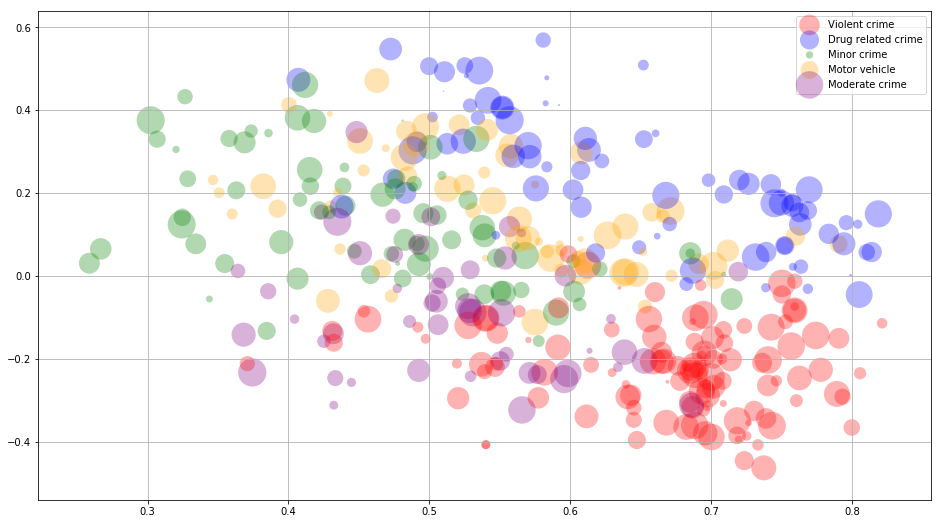

In [84]:
plot_embeddings(charge_desc_dict.keys())

In [85]:
reduced_embeddings_3 = reduce_to_k_dim(message_embeddings, 3)

Running Truncated SVD over 390 words...
Done.


In [86]:
print(reduced_embeddings_3.shape)

(390, 3)


In [87]:
charge2ReducedEmbedding = {}
for c, i in zip(charge_desc_dict.keys(), range(len(charge_desc_dict))):
    charge2ReducedEmbedding[c] = reduced_embeddings_3[i]

In [88]:
colors = ['green', 'purple', 'blue', 'orange', 'red']
labels = ['Minor crime', 'Moderate crime', 'Drug related crime', 'Motor vehicle', 'Violent crime']
labels_use = [0, 0, 0, 0, 0]

In [89]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [16,9]
def plot_embeddings(charges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for c in charges:
        L = charge_desc_dict[c]
        scale = 100.0 
        ax.scatter(charge2ReducedEmbedding[c][0],
                    charge2ReducedEmbedding[c][1],
                    charge2ReducedEmbedding[c][2],
                    c=colors[charge_desc_dict[c]],
                    alpha=0.3, edgecolors='none',
                    s=scale,
                    label=labels[L] if labels_use[L] == 0 else "")
        labels_use[charge_desc_dict[c]] = 1
    ax.legend()
    ax.grid(True)
    plt.show()

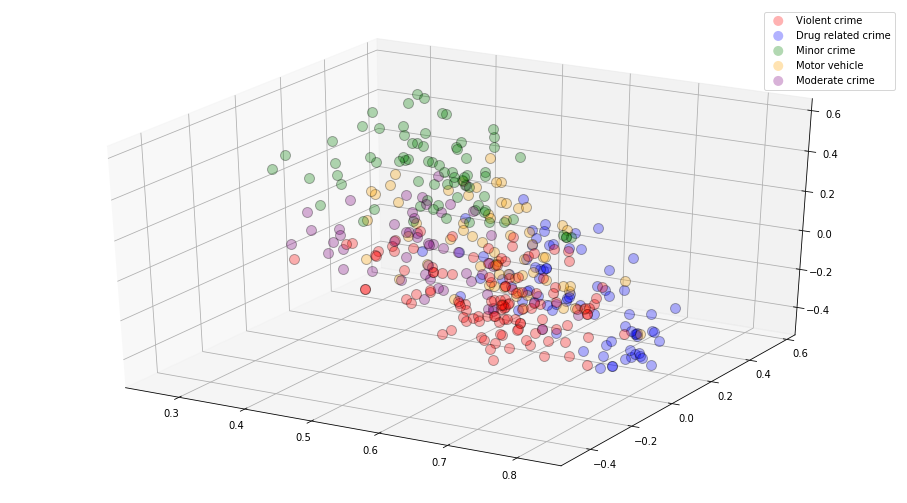

In [90]:
plot_embeddings(charge_desc_dict.keys())

## Feature Engineering
### Charge description feature
The COMPAS dataset contains 'charge description' written at the time of conviction.  It is associated with a categorical label called 'charge degree'. The charge degree has two distinct values, F: felony and M: misdemeanor.  The charge description is a free form text in English.  It is a short description of the crime with lots of abbreviations and is domain specific.
We decided to extract more information from the charge descriptions beyond just the two categories provided in the charge degree believing that it could have some correlation with the recidivism rate.
In first attempt, we converted the charge description to TF-IDF sparse vectors and applied kmeans with k = 5.  The study of resulting groups revealed that the clustering failed to capture meaningful grouping of the crimes by types or severity.
Next, we converted the charge description to sentence vectors using universal sentence encoder. The resulting sentence vector is a semantic vector in 512 dimensions. The application of kmeans clustering algorithm with k = 5 we were able to group various charges in a very meaningful group. Analysis revealed that groups formed through unsupervised kmeans algorithm neatly segregated drug related charges, traffic violations / offences, minor, moderate and violent crimes.  The top left to bottom right direction shows increased severity of the crime.   
The newly extracted feature is a categorial feature with 5 distinct values.  We plotted the each charge description by first converting the sentence vectors to 2 dimensional vectors through Truncated SVD.

TODO: Describe the impact of the feature if any.

Reference: Universal Sentence Encoder
    https://arxiv.org/abs/1803.11175